In [1]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc
import seaborn as sns

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle as pkl

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Plotting function**

In [2]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name):
    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    # Set a color palette for better color representation
    sns.set_palette("colorblind")

    # Plot the PCA with random reordering
    sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, s=20)

    # Plot the UMAP with random reordering
    sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, s=20)

    # Show the plots
    plt.show()

**Code**

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [4]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))

In [5]:
ckpt_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_base_checkpoint.pth"

In [6]:
state_dict = torch.load(ckpt_path)

**Load model weights**

In [7]:
config["model"]["arch"]

'vit_base'

In [16]:
model = vits.__dict__[config["model"]["arch"]](
                img_size=[96],
                patch_size=16,
                in_chans=6
            )

embed_dim = model.embed_dim

In [17]:
config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

In [18]:
embed_dim

768

In [19]:
for p in model.parameters():
    p.requires_grad = False

In [20]:
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(6, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [21]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"

In [22]:
state_dict = torch.load(pretrained_weights)

In [23]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

In [ ]:
model

**Featurize cells**

In [ ]:
img = torch.randn(16, 5, 96, 96).cuda()

In [ ]:
feat = model(img)

In [ ]:
feat.shape

**Featurize RxRx1 before and after batchn transformation**

In [ ]:
args = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 32,
    'val_batch_size': 20,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,

    # Lightning
    'filename': 'epoch_{epoch:04d}',
    'monitor': 'fid_transformations',
    'mode': 'min',
    'save_last': True,
    'offline': False,
    'project': 'rxrx1_batch',
    'log_model': False,
    'accelerator': 'gpu',
    'log_every_n_steps': 10
}
args = OmegaConf.create(args)

In [ ]:
dataloader = CellDataLoader(args)

In [ ]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20231220_cbfc860a-2302-457a-b6d9-732d5b776510_rxrx1_batch"

In [ ]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(53)

In [ ]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [ ]:
X_before_transf = []
X_after_transf = []

features = {"batch": [],
            "plate": [],
            "well": [],
            "view": [],
            "no": []}

In [ ]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                batch, plate, well, view, no = filename.split("-")[1].split("_")
                features["batch"].append(batch)
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            Z_before_transf = model(X[:, :-1, :, :])
            Z_after_transf = model(X_generated[:, :-1, :, :])

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

In [38]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [39]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [40]:
sc.tl.pca(adata_before_transf)
sc.pp.neighbors(adata_before_transf)
sc.tl.umap(adata_before_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


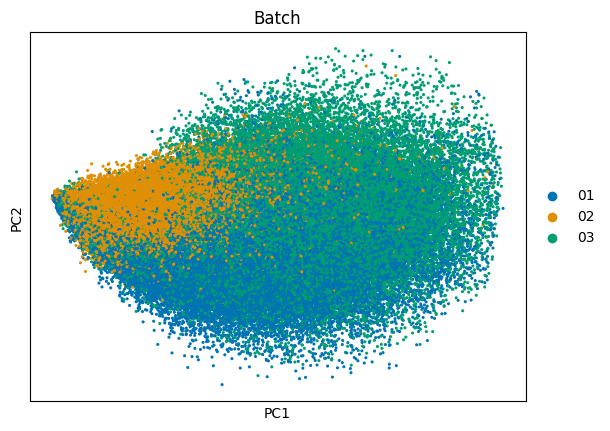

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


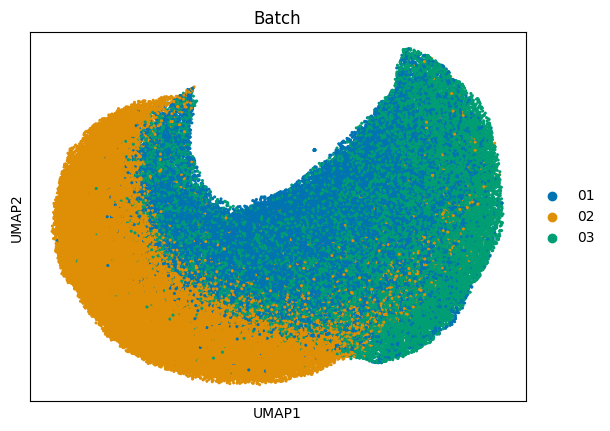

In [13]:
pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "batch")

After correction

In [42]:
sc.tl.pca(adata_after_transf)
sc.pp.neighbors(adata_after_transf)
sc.tl.umap(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


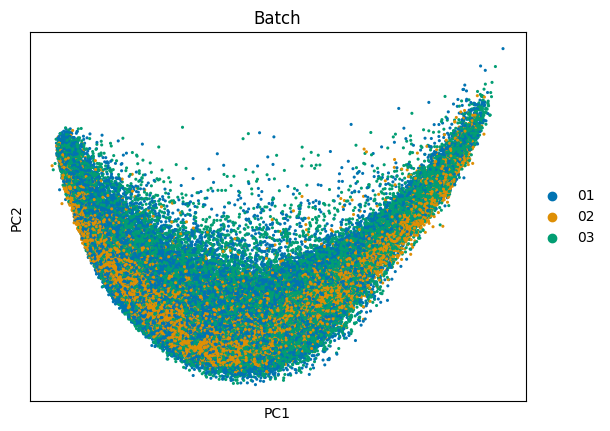

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


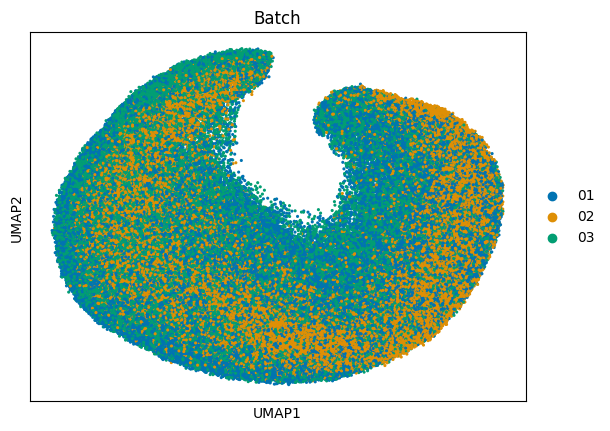

In [14]:
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "batch")

Save results

In [6]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata")

In [7]:
# adata_before_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [8]:
# adata_after_transf.write_h5ad(feature_dest_folder / "rxrx1_adata_after_transf.h5ad")

In [9]:
adata_before_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_before_transf.h5ad")

In [10]:
adata_after_transf = sc.read_h5ad(feature_dest_folder / "rxrx1_adata_after_transf.h5ad")

## Add compounds to anndata

In [9]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)
data_index

,Unnamed: 0,BATCH,PLATE,WELL,VIEW,CPD_NAME,ANNOT,CELL_LINE,DOSE,SPLIT
SAMPLE_KEY,,,,,,,,,,
U2OS-01_1_B02_s1_14,0,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_15,1,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_16,2,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
U2OS-01_1_B02_s1_17,3,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,test
U2OS-01_1_B02_s1_19,4,U2OS-01,1,B02,s1,UNTREATED,negative_control,U2OS,NaN,train
...,...,...,...,...,...,...,...,...,...,...
U2OS-03_3_O23_s2_8,181260,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,train
U2OS-03_3_O23_s2_9,181261,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,test
U2OS-03_3_O23_s2_10,181262,U2OS-03,3,O23,s2,TSFM,treated,U2OS,NaN,train


In [10]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [11]:
adata_before_transf.obs["compound"] = compound_names

In [12]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scib metrics

In [72]:
adata_unique = adata_before_transf.copy()

In [73]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"]

In [74]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"]

In [75]:
adata_unique

AnnData object with n_obs × n_vars = 170942 × 768
    obs: 'batch', 'plate', 'well', 'view', 'no', 'compound'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'Unintegrated', 'IMPA-Integrated'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata_unique,
    batch_key="batch",
    label_key="compound",
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated"],
    n_jobs=6,
)
bm.benchmark()

In [18]:
scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/rxrx1.pkl"

In [19]:
# with open(scib_path, "wb") as file:
#     pkl.dump(bm, file)

In [20]:
with open(scib_path, "rb") as file:
    b = pkl.load(file)

**Plot scib metrics**

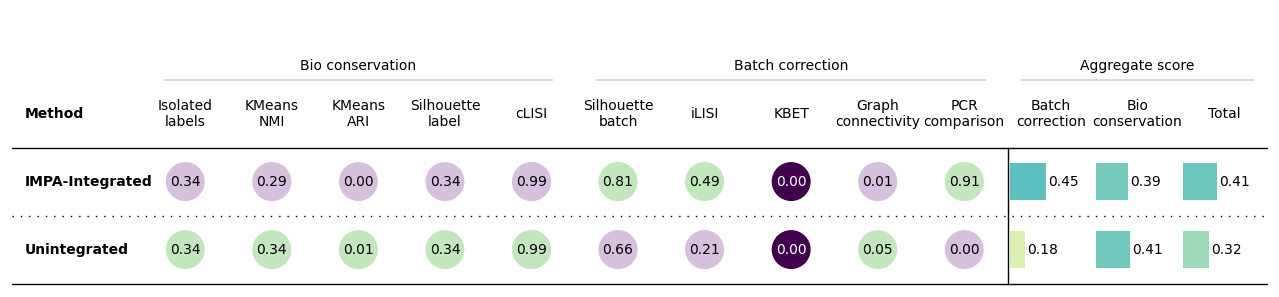

In [21]:
b.plot_results_table(min_max_scale=False)

In [28]:
df = b.get_results(min_max_scale=False)
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
Unintegrated,0.34388,0.344531,0.00691,0.342858,0.990328,0.66195,0.213712,0.0,0.048428,0,0.184818,0.405701,0.317348
IMPA-Integrated,0.339105,0.28832,0.001437,0.338717,0.988953,0.813499,0.488094,0.0,0.014122,0.909972,0.445137,0.391306,0.412839
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [32]:
df.index

Index(['Unintegrated', 'IMPA-Integrated', 'Metric Type'], dtype='object', name='Embedding')

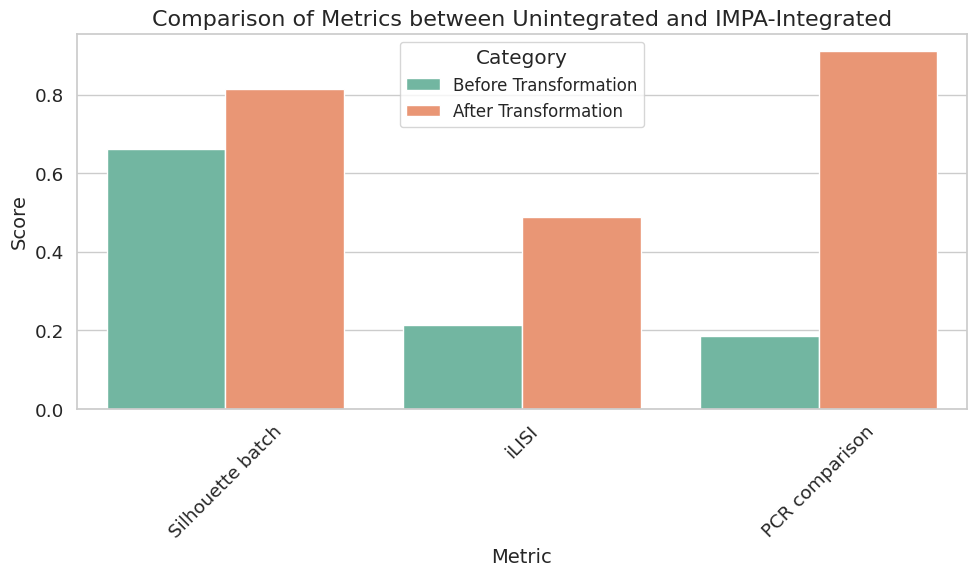

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'Category': ['Before Transformation', 
                 'Before Transformation', 
                 'Before Transformation', 
                 'After Transformation', 
                 'After Transformation', 
                 'After Transformation'],
    'Metric': ['Silhouette batch', 'iLISI', 'PCR comparison', 'Silhouette batch', 'iLISI', 'PCR comparison'],
    'Score': [0.66195, 0.213712, 0.184818, 0.813499, 0.488094, 0.909972]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Set aesthetic parameters
sns.set(style='whitegrid', font_scale=1.2)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2")  # Choose a suitable color palette
sns.barplot(data=df, x='Metric', y='Score', hue='Category', palette=palette)
plt.title('Comparison of Metrics between Unintegrated and IMPA-Integrated', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(title='Category', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


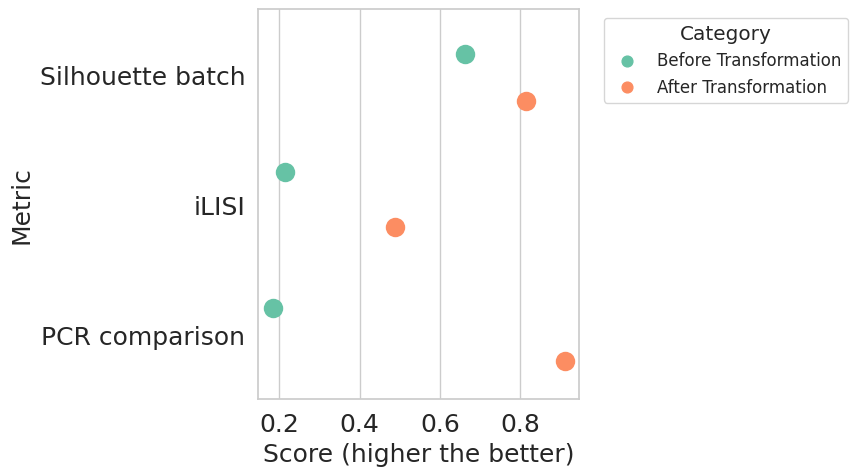

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
# Data from the table
data = {
    'Category': ['Before Transformation', 
                 'Before Transformation', 
                 'Before Transformation', 
                 'After Transformation', 
                 'After Transformation', 
                 'After Transformation'],
    'Metric': ['Silhouette batch', 'iLISI', 'PCR comparison', 'Silhouette batch', 'iLISI', 'PCR comparison'],
    'Score': [0.66195, 0.213712, 0.184818, 0.813499, 0.488094, 0.909972]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Set aesthetic parameters
sns.set(style='whitegrid', font_scale=1.2)

# Plotting with Seaborn - Horizontal Point plot (Swarm plot)
plt.figure(figsize=(9, 5))
palette = sns.color_palette("Set2")  # Choose a suitable color palette
sns.stripplot(data=df, y='Metric', x='Score', hue='Category', palette=palette, dodge=True, jitter=True, size=14)  # Increase size here
plt.title('', fontsize=16)
plt.xlabel('Score (higher the better)', fontsize=18)
plt.ylabel('Metric', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Place legend outside the plot
plt.legend(title='Category', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

